In [1]:
%pylab inline
from scipy.special import spherical_jn
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erf
from classy import Class

Populating the interactive namespace from numpy and matplotlib


## PARAMETERS

In [4]:
# ell ranges
l_arr = np.arange(2,100,1)

# power spectra
non_linear = True # whether to use halofit for scalar power spectra

# cosmology
h = 0.7
A_s = 1.95e-9
n_s = 0.96
Omega_b = 0.049
omega_cdm = (0.3-0.049)*0.7**2.

# Tensor parameters
k0 = 0.05 # pivot scale in 1/Mpc
rT_fid = 1. # fiducial amplitude
chirality_fid = 1. # chirality parameter
n_t = -rT_fid/8. # power law index

# Sky fraction
f_sky = 0.36

# n(z) parameters
n_type = 'VRO' # 'euclid' or 'VRO'
if n_type=='VRO':
    alpha = 2.
    beta = 1.
    z0 = 0.3
elif n_type=='euclid':
    alpha = 2.
    z0 = 0.64
    beta = 3./2
else:
    raise Exception("Incorrect n-type")

# W(z) parameters
w_type = 'equal-chi' # 'equal-chi' or 'equal-source' or 'gaussian'
if w_type=='equal-chi': # equal chi per bin
    n_tomo = 6
    z_min = 0.
    z_max = 6.
elif w_type=='equal-source': # equal number of sources per bin
    n_tomo = 6
elif w_type=='gaussian': # gaussian n(z)
    z_cen = 2.
    z_width = 0.03
    n_tomo = 1
else:
    raise Exception("Incorrect w-type")
    
# Noise parameters
## from 2107.09000, as relevant to Euclid
sigma_gamma = 0.4 # from 2005.04604, dimensionless
nbar_gal_arcmin = 40.
nbar_gal = nbar_gal_arcmin*(60.*180./np.pi)**2.

### Load Power Spectra

In [5]:
### CLASS VERSION
cc = Class()
cc.set({'h':h,'Omega_b':Omega_b,'A_s':A_s,'n_s':n_s,'T_cmb':2.73,
        'output':'mPk, mTk, lCl, tCl, pCl',
        'lensing':'Yes','l_max_scalars':10000,
        'l_switch_limber':9,
        'non linear':'halofit','P_k_max_1/Mpc':1000,
        'omega_cdm':omega_cdm,'z_max_pk':10})
cc.compute()
if non_linear: pk_input = np.vectorize(lambda k: cc.pk_lin(k,0))
else: pk_input = np.vectorize(lambda k: cc.pk(k,0))
Om = cc.Omega0_m()
H0 = cc.Hubble(0)
c = 1.

## Set-Up

In [6]:
# Redshift
z_arr = np.geomspace(1e-6,10,3001)

# Wavenumber (in 1/Mpc units)
k_arr = np.logspace(-6,1.,3000)
k0_arr = k_arr[:,np.newaxis]

# Conformal time today
eta0 = cc.get_current_derived_parameters(['conformal_age'])['conformal_age']

# Growth Factor
Dz_arr = np.asarray([cc.scale_independent_growth_factor(zz) for zz in z_arr])

# Comoving distance
chi_arr = np.asarray([np.sqrt(cc.luminosity_distance(zz)*cc.angular_distance(zz)) for zz in z_arr])

# Recombination distance
z_dec = cc.get_current_derived_parameters(['z_d'])['z_d']
chi_dec = np.sqrt(cc.luminosity_distance(z_dec)*cc.angular_distance(z_dec))

# Power Spectra in 1/Mpc units
Pk_delta_z0 = InterpolatedUnivariateSpline(k_arr,pk_input(k_arr),ext='zeros')

# Potential Spectra (factor of 0.9 is potential growth factor for superhorizon modes)
Pk_Psi_z0 = lambda k: Pk_delta_z0(k)/k**4.*(3./2.*H0**2.*Om)**2./0.9**2.

# Scale factor
a_arr = 1./(1.+z_arr)

# Matter transfer function
T_all = cc.get_transfer(0.,'class')
kTk = T_all['k (h/Mpc)']
Tk = T_all['d_cdm']

# Compute interpolator for curvature power spectrum and transfer function
Tk_interp = InterpolatedUnivariateSpline(kTk*h,Tk,ext='zeros')

#### Redshift Distribution

In [7]:
dz_dchi = InterpolatedUnivariateSpline(0.5*(z_arr[:-1]+z_arr[1:]),np.diff(z_arr)/np.diff(chi_arr))(z_arr)
n_z = (z_arr/z0)**alpha*np.exp(-(z_arr/z0)**beta)

# Normalize such that integrated n_z measures number of galaxies per steradian
n_z_norm = simps(n_z,z_arr)
n_z /= n_z_norm

# Convert to n_chi
n_chi = n_z*dz_dchi

# Split this into z bins
if w_type=='equal-chi':
    weighting = 1.
elif w_type=='equal-source':
    weighting = n_chi
elif w_type=='gaussian':
    weighting = np.exp(-(z_arr-z0)**2./(2.*z_width**2.*(1.+z_arr)**2.))
dchi = np.gradient(chi_arr)
partial_sum = np.cumsum(weighting*dchi)/np.sum(weighting*dchi)

z_cuts = [np.where(partial_sum>float(i)/n_tomo)[0][0] if i < n_tomo else -1 for i in range(n_tomo+1)]
ii = np.arange(len(n_chi))
chi_cuts = chi_arr[z_cuts].astype(int)
if w_type=='equal-source':
    n_chis_split = [n_chi*(chi_arr<chi_cuts[i+1])*(chi_arr>chi_cuts[i]) for i in range(n_tomo)]
    n_chis = [n_chis_split[i]/simps(n_chis_split[i],chi_arr) for i in range(n_tomo)]
    W_chis_split = n_chis_split/n_chi
    W_chis = [W_chis_split[i]/simps(W_chis_split[i],chi_arr) for i in range(n_tomo)]
else:
    W_chis_split = [weighting*(chi_arr<chi_cuts[i+1])*(chi_arr>chi_cuts[i]) for i in range(n_tomo)]
    W_chis = [W_chis_split[i]/simps(W_chis_split[i],chi_arr) for i in range(n_tomo)]
    n_chis_split = W_chis_split*n_chi
    n_chis = [n_chis_split[i]/simps(n_chis_split[i],chi_arr) for i in range(n_tomo)]

# Compute source density per bin
n_av = [simps(W_chis_split[i]*n_chi,chi_arr)**2/simps(n_chi*W_chis_split[i]**2,chi_arr)*nbar_gal for i in range(n_tomo)]
del n_chi

chi_dec = 1.36e+04


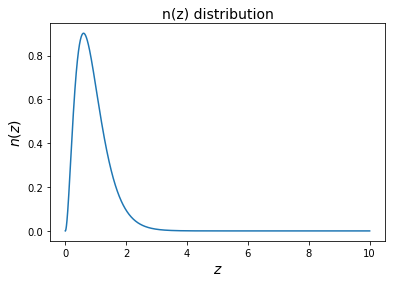

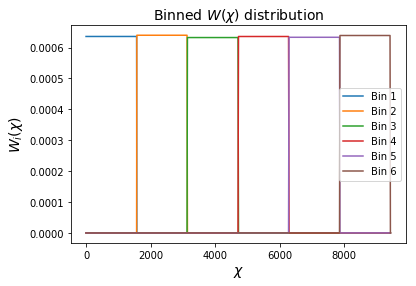

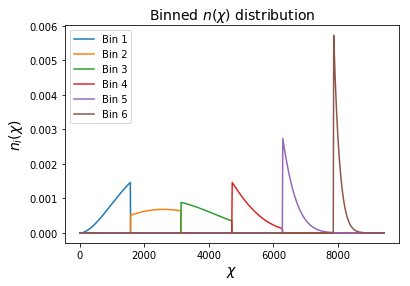

In [8]:
plt.title('n(z) distribution',fontsize=14)
plt.plot(z_arr,n_z)
plt.xlabel(r'$z$',fontsize=14)
plt.ylabel(r'$n(z)$',fontsize=14)

print("chi_dec = %.2e"%chi_dec)
plt.figure()
plt.title(r'Binned $W(\chi)$ distribution',fontsize=14)
for i in range(n_tomo):
    plt.plot(chi_arr,W_chis[i],label='Bin %d'%(i+1))
plt.xlabel(r'$\chi$',fontsize=14)
plt.ylabel(r'$W_i(\chi)$',fontsize=14)
plt.legend()

plt.figure()
plt.title(r'Binned $n(\chi)$ distribution',fontsize=14)
for i in range(n_tomo):
    plt.plot(chi_arr,n_chis[i],label='Bin %d'%(i+1))
plt.xlabel(r'$\chi$',fontsize=14)
plt.ylabel(r'$n_i(\chi)$',fontsize=14)
plt.legend()

#### Compute $q(\chi)$ and $m(\chi)$
$m_a(\chi) = \int_\chi^{\infty} d\chi_S\,W_a(\chi_S)$ which parametrizes which redshifts can lens a given bin of sources, and $q_a(\chi) = \int_{\chi}^\infty d\chi_S\,\left[\frac{\chi-\chi_S}{\chi_S}\right]n_a(\chi_S)$, for some source-weighted binning function $n_a(\chi)$.

In [9]:
chiS_arr = chi_arr[None,:]
chiL_arr = chi_arr[:,None]
q_chis = [simps(n_chis[i][None,:]*(chiS_arr-chiL_arr)/chiS_arr*(chiS_arr>chiL_arr),chiS_arr,axis=1) for i in range(n_tomo)]
m_chis = [simps(n_chis[i][None,:]*(chiS_arr>chiL_arr),chiS_arr,axis=1) for i in range(n_tomo)]
# m2 chi is same but with extra factor of chiL_arr/chiS_arr
m2_chis = [simps(n_chis[i][None,:]*(chiS_arr>chiL_arr)*chiL_arr/chiS_arr,chiS_arr,axis=1) for i in range(n_tomo)]

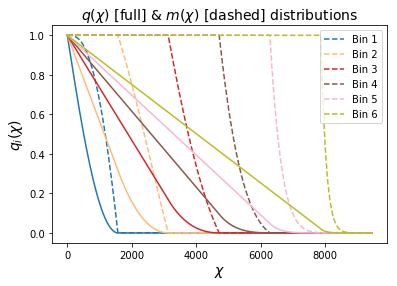

In [10]:
plt.figure()
plt.title(r'$q(\chi)$ [full] & $m(\chi)$ [dashed] distributions',fontsize=14)
cs = cm.tab20
for i in range(n_tomo):
    plt.plot(chi_arr,m_chis[i],label='Bin %d'%(i+1),ls='--',c=cs(i*1./n_tomo))
    plt.plot(chi_arr,q_chis[i],c=cs(i*1./n_tomo))
plt.xlabel(r'$\chi$',fontsize=14)
plt.ylabel(r'$q_i(\chi)$',fontsize=14)
plt.legend()

## Set-Up

In [11]:
### Useful shear + kSZ quantities

# IA bias
C1S_rhocr0 = 0.1
bias_IA_chi = (2./3.)*C1S_rhocr0/H0**2.*(1.+0.*chi_arr)

print("Assuming intrinsic alignment bias of %.3f (in 2/(3 Omega_m H_0^2) units)"%(3.*Om*H0**2./2.*bias_IA_chi.mean()))

# Equality scale
z_eq = cc.Omega_m()/(1.-cc.Omega_Lambda()-cc.Omega_m())-1 # including neutrinos!
a_eq = 1./(1.+z_eq)

# chi array up to recombination
z_all = np.geomspace(1e-6,2000,1003)
chi_all = np.asarray([np.sqrt(cc.luminosity_distance(zz)*cc.angular_distance(zz)) for zz in z_all])
a_all = 1./(1.+z_all)

def D_psi_a(a):
    """Potential time-dependence, valid on sub- and super-horizon scales. See 0808.1570"""
    y = a/a_eq
    a_all2 = np.linspace(0.00001,a,10000)
    fac1 = (16.*np.sqrt(1.+y)+9.*y**3.+2.*y**2.-8.*y-16.)/(10.*y**3.)
    fac2 = (5./2.*Om*np.sqrt(Om/a**3.+1.-Om)/a)
    fac3 = simps((a_all2<a)/np.sqrt(Om/a_all2**3.+1.-Om)**3./a_all2**3.,a_all2)
    return fac1*fac2*fac3
D_psi_all = np.asarray([D_psi_a(a) for a in a_all])
D_psi_arr = np.asarray([D_psi_a(a) for a in a_arr])

D_psi = InterpolatedUnivariateSpline((eta0-chi_all)[::-1],D_psi_all[::-1],ext=0)
deriv_D_psi = lambda eta: (D_psi(eta*1.001)-D_psi(eta*0.999))/(0.002*eta)

H_a = lambda a: cc.Hubble(1./a-1.)

# Velocity time dependence
def D_v_a(a):
    """Velocity time-dependence, from 0808.1570"""
    y = a/a_eq
    part1 = 2.*a**2.*H_a(a)/(H0**2.*cc.Omega0_m())*y/(4.+3.*y)
    part2 = D_psi_a(a)+(D_psi_a(a*1.001)-D_psi_a(a*0.999))/0.002
    out = part1*part2
    return out

filt = z_all>1e-3
D_v = InterpolatedUnivariateSpline((eta0-chi_all[filt])[::-1],np.asarray([D_v_a(a) for a in a_all[filt]])[::-1],ext=0)

Assuming intrinsic alignment bias of 0.030 (in 2/(3 Omega_m H_0^2) units)


### Plot growth functions

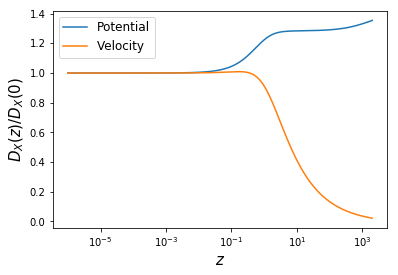

In [12]:
plt.plot(z_all,D_psi(eta0-chi_all)/D_psi(eta0),label='Potential')
plt.plot(z_all,D_v(eta0-chi_all)/D_v(eta0),label='Velocity')
plt.xscale('log')
plt.legend(fontsize=12)
plt.xlabel(r'$z$',fontsize=15)
plt.ylabel(r'$D_X(z)/D_X(0)$',fontsize=15);

In [13]:
# Define dipole transfer functions
def K_SW(chiE):
    return 3.*(2.*D_psi(eta0-chi_dec)-3./2.)*spherical_jn(1,k_arr*(chi_dec-chiE))
def K_ISW(chiE):
    chiT_arr = np.linspace(chiE+0.00001,chi_dec,101)
    return 6.*simps(deriv_D_psi(eta0-chiT_arr)*spherical_jn(1,k0_arr*(chiT_arr-chiE)),chiT_arr)
def K_Doppler(chiE):
    return k_arr*D_v(eta0-chi_dec)*(spherical_jn(0,k_arr*(chi_dec-chiE))-2.*spherical_jn(2,k_arr*(chi_dec-chiE)))-k_arr*D_v(eta0-chiE)

### Plot $\mathcal{K}$ kernels

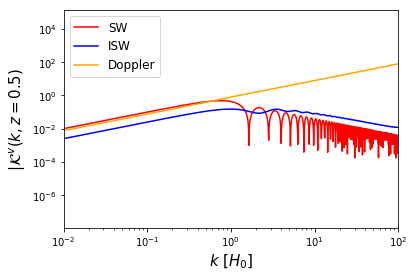

In [14]:
K_SW_arr = []
K_ISW_arr = []
K_Doppler_arr = []
for i,chiE in enumerate(chi_arr):
    K_SW_arr.append(K_SW(chiE))
    K_ISW_arr.append(K_ISW(chiE))
    K_Doppler_arr.append(K_Doppler(chiE))
K_SW_arr = np.asarray(K_SW_arr).T
K_ISW_arr = np.asarray(K_ISW_arr).T
K_Doppler_arr = np.asarray(K_Doppler_arr).T

z_i = np.argmin(np.abs(z_arr-0.5))
plt.plot(k_arr/H0,np.abs(K_SW_arr[:,z_i]),ls='-',c='r',label='SW')
plt.plot(k_arr/H0,np.abs(K_ISW_arr[:,z_i]),ls='-',c='b',label='ISW')
plt.plot(k_arr/H0,np.abs(K_Doppler_arr[:,z_i]),ls='-',c='orange',label='Doppler')
plt.legend(fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.01,100])
plt.ylabel(r'$|\mathcal{K}^v(k,z=%.1f)$'%z_arr[z_i],fontsize=15)
plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);

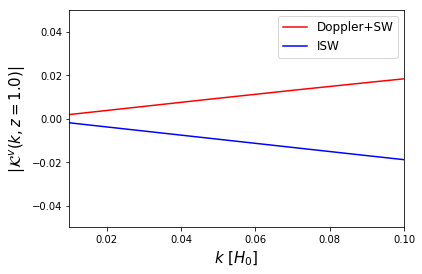

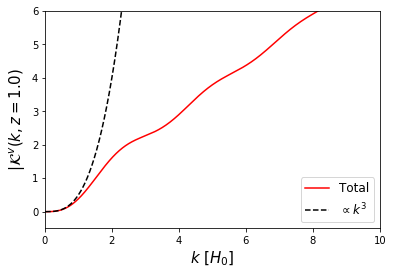

In [15]:
z_i = np.argmin(np.abs(z_arr-1.))
plt.plot(k_arr/H0,K_SW_arr[:,z_i]+K_Doppler_arr[:,z_i],ls='-',c='r',label='Doppler+SW')
plt.plot(k_arr/H0,K_ISW_arr[:,z_i],ls='-',c='b',label='ISW')
plt.legend(fontsize=12)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim([0.01,0.1])
plt.ylim([-0.05,0.05])
plt.ylabel(r'$|\mathcal{K}^v(k,z=%.1f)|$'%z_arr[z_i],fontsize=15)
plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);

plt.figure()
plt.plot(k_arr/H0,-(K_SW_arr[:,z_i]+K_Doppler_arr[:,z_i]+K_ISW_arr[:,z_i]),ls='-',c='r',label='Total')
plt.plot(k_arr/H0,(k_arr/H0)**3*0.5,ls='--',c='k',label=r'$\propto k^3$')
plt.legend(fontsize=12)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim([0.01,10.])
plt.ylim([-0.5,6])
plt.ylabel(r'$|\mathcal{K}^v(k,z=%.1f)$'%z_arr[z_i],fontsize=15)
plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);

## Scalar Kernels

**Shear Kernels**
\begin{eqnarray}
    \Delta_\ell^{\gamma^E,\rm S}(k,\chi) = i^{\ell}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\left[-\frac{b_S(\chi)}{2\chi^2}D_\Psi(\eta_0-\chi)j_\ell(k\chi)+\frac{1}{c^2}\int_0^\chi\frac{d\chi'}{\chi'}\left(\frac{\chi'-\chi}{\chi}\right)D_\Psi(\eta_0-\chi')j_\ell(k\chi')\right].
\end{eqnarray}

with $b_{\rm S}(\chi)\equiv(2/3)C^{\rm S}_{1}\rho_{cr0}H_0^{-2}$ for $\rho_{cr0}=3H_0^2/(8\pi G)$, and $C_1^{\rm S}\rho_{cr0}\sim 0.1$.

On redshift integration:
\begin{eqnarray}
    \Delta_{\ell,a}^{\gamma^E,\rm S}(k) = i^{\ell}\sqrt{\frac{(\ell+2)!}{(\ell-2)!}}\left[-\int d\chi\,n_a(\chi)\frac{b_S(\chi)}{2\chi^2}D_\Psi(\eta_0-\chi)j_\ell(k\chi)+\frac{1}{c^2}\int_0^\chi\frac{d\chi'}{\chi'}q_a(\chi')D_\Psi(\eta_0-\chi')j_\ell(k\chi')\right].
\end{eqnarray}

**kSZ Kernels**
\begin{eqnarray}
    \Delta_\ell^{v,\rm S}(k,\chi) = \frac{i^\ell}{2\ell+1}\left[\mathcal{K}_{\rm SW}+\mathcal{K}_{\rm ISW}+\mathcal{K}_{\rm Doppler}\right](k,\chi)\left[\ell j_{\ell-1}(k\chi)-(\ell+1)j_{\ell+1}(k\chi)\right].
\end{eqnarray}
for kernels
\begin{eqnarray}
    \mathcal{K}_{\rm SW}(k,\chi) &=& 3\left(2D_\Psi(\eta_d)-\frac{3}{2}\right)j_1(k[\chi_d-\chi])\\\nonumber
    \mathcal{K}_{\rm ISW}(k,\chi) &=& 6\int_{\chi}^{\chi_d} d\bar\chi\,\partial_\eta D_\Psi(\bar\eta)j_1(k[\bar\chi-\chi])\\\nonumber
    \mathcal{K}_{\rm Doppler}(k,\chi) &=& kD_v(\eta_d)\left(j_0(k[\chi_d-\chi])-2j_2(k[\chi_d-\chi])\right)-kD_v(\eta)
\end{eqnarray}
where $D_\Psi$ is the $\Psi$ growth rate and $D_v$ is the velocity potential growth rate. On redshift integration:
\begin{eqnarray}
    \Delta_{\ell,a}^{v,\rm S}(k) = \frac{i^{\ell}}{2\ell+1}\int d\chi\,n_a(\chi)\left[\mathcal{K}_{\rm SW}+\mathcal{K}_{\rm ISW}+\mathcal{K}_{\rm Doppler}\right](k,\chi)\left[\ell j_{\ell-1}(k\chi)-(\ell+1)j_{\ell+1}(k\chi)\right].
\end{eqnarray}

**Galaxy Kernels**
\begin{eqnarray}
    \Delta_\ell^{g,\rm S}(k,\chi) = -i^\ell\frac{2a(\chi)k^2}{3H_0^2\Omega_m}b_g(\chi)D_{\Psi}(\chi)j_\ell(k\chi),
\end{eqnarray}
for galaxy bias $b_g$.

In [16]:
### Compute all required Bessel functions
all_l = np.arange(0,max(l_arr)+2)
all_jl = [spherical_jn(l,k0_arr*chi_arr) for l in all_l]

# Compute galaxy bias
bz_arr = 0.95/Dz_arr

In [17]:
def compute_scalar_kernels(l):
    """Compute the Delta_ell(k, chi) kernels, integrated over redshift bins, for scalar sources."""
    
    assert l>=1
    
    # Bessel functions
    x = k0_arr*chi_arr
    jl = all_jl[l]
    jl1 = all_jl[l+1]
    jlm1 = all_jl[l-1]
    
    # Bessel function derivatives
    djl = l/x*jl-jl1
    d2jl = (l*(l-1)-x**2.)/x**2.*jl+2./x*jl1
    d3jl = (l-2)*(l*(l-1)-x**2.)/x**3.*jl+(x**2.-l*(l-1.)-6.)/x**2.*jl1
    d4jl = ((l-3)*(l-2)*(l-1)*l-2.*(l*(l-1)+4)*x**2.+x**4.)/x**4.*jl + 4.*(6.+2*l*(l+1.)-x**2.)/x**3.*jl1
    
    # Initialize kernels
    kernel_gE_scalar_IA = []
    kernel_gE_scalar_lens = []
    kernel_gE_scalar_tot = []
    
    kernel_v_scalar_SW = []
    kernel_v_scalar_ISW = []
    kernel_v_scalar_Doppler = []
    kernel_v_scalar_tot = []
    
    kernel_gal_scalar = []
    
    # Iterate over redshift bins
    for i in range(n_tomo):
        
        pref_gE = ((1.0j)**l)*np.sqrt((l+2.)*(l+1.)*l*(l-1.))
        pref_v = (1.0j)**l/(2.*l+1.)
        pref_g = (1.0j)**l
        
        # Shear
        kernel_gE_scalar_IA.append(-pref_gE*simps(n_chis[i]*bias_IA_chi/(2.*chi_arr**2.)*D_psi_arr*jl,chi_arr))
        kernel_gE_scalar_lens.append(pref_gE/c**2.*simps(q_chis[i]/chi_arr*D_psi_arr*jl,chi_arr))
        kernel_gE_scalar_tot.append(kernel_gE_scalar_IA[-1]+kernel_gE_scalar_lens[-1])

        # kSZ 
        jl_piece = l*jlm1-(l+1.)*jl1
        kernel_v_scalar_SW.append(pref_v*simps(n_chis[i]*K_SW_arr*jl_piece,chi_arr))
        kernel_v_scalar_ISW.append(pref_v*simps(n_chis[i]*K_ISW_arr*jl_piece,chi_arr))
        kernel_v_scalar_Doppler.append(pref_v*simps(n_chis[i]*K_Doppler_arr*jl_piece,chi_arr))
        kernel_v_scalar_tot.append(kernel_v_scalar_SW[-1]+kernel_v_scalar_ISW[-1]+kernel_v_scalar_Doppler[-1])
        
        # Galaxies
        kernel_gal_scalar.append(pref_g*-2./(3.*H0**2.*Om)*simps(n_chis[i]*a_arr*bz_arr*D_psi_arr*jl*k0_arr**2.,chi_arr))
    return kernel_gE_scalar_IA, kernel_gE_scalar_lens, kernel_gE_scalar_tot, kernel_v_scalar_SW, kernel_v_scalar_ISW, kernel_v_scalar_Doppler, kernel_v_scalar_tot, kernel_gal_scalar

all_kernels = np.asarray([compute_scalar_kernels(l) for l in l_arr])

shear_kernels_scalar, ksz_kernels_scalar, gal_kernels_scalar = all_kernels[:,:3], all_kernels[:,3:7], all_kernels[:,7]

### Plot scalar kernels

/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


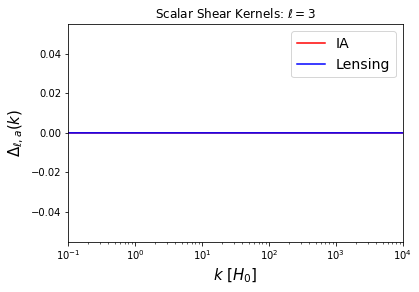

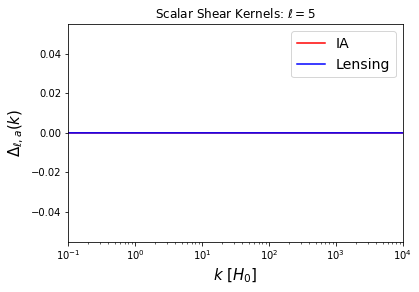

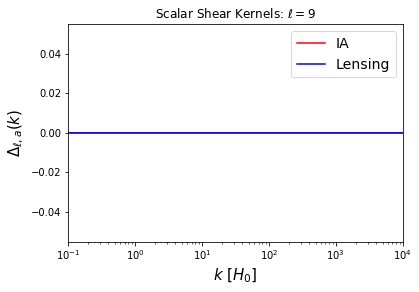

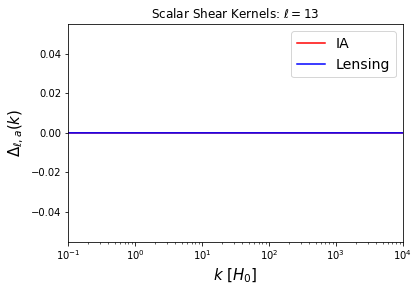

In [18]:
bin_index = 0
for i in [1,3,7,11]:
    plt.figure()
    plt.title('Scalar Shear Kernels: $\ell = %d$'%l_arr[i])
    plt.plot(k_arr/H0,shear_kernels_scalar[i][0][bin_index],label=r'IA',c='r')
    plt.plot(k_arr/H0,shear_kernels_scalar[i][1][bin_index],label=r'Lensing',c='b')
    plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);
    plt.legend(fontsize=14)
    plt.ylabel(r'$\Delta_{\ell,a}(k)$',fontsize=15);
    plt.xscale('log')
    plt.xlim([1e-1,1e4])

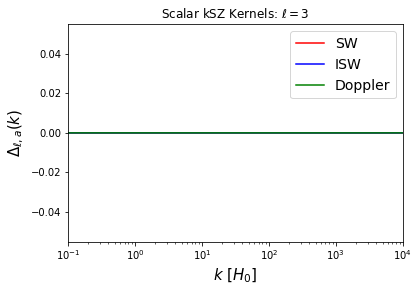

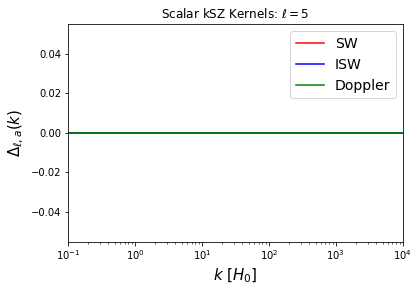

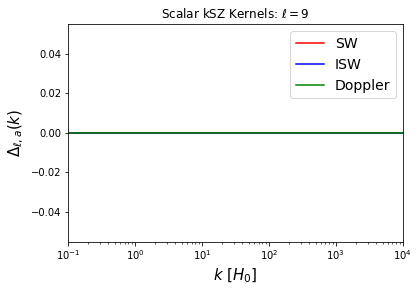

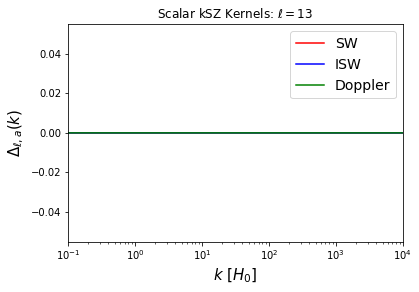

In [19]:
for i in [1,3,7,11]:
    plt.figure()
    plt.title('Scalar kSZ Kernels: $\ell = %d$'%l_arr[i])
    plt.plot(k_arr/H0,ksz_kernels_scalar[i][0][bin_index],label=r'SW',c='r')
    plt.plot(k_arr/H0,ksz_kernels_scalar[i][1][bin_index],label=r'ISW',c='b')
    plt.plot(k_arr/H0,ksz_kernels_scalar[i][2][bin_index],label=r'Doppler',c='g')
    plt.xlabel(r'$k\,\,[H_0]$',fontsize=15);
    plt.legend(fontsize=14)
    plt.ylabel(r'$\Delta_{\ell,a}(k)$',fontsize=15);
    plt.xscale('log')
    plt.xlim([1e-1,1e4])

## Scalar Spectra

Spectra:
$$C_{\ell,ab}^{XY} = 4\pi\int_{0}^\infty d\log k\,\Delta^X_{\ell,a}(k)\Delta^{Y*}_{\ell,b}(k)\mathcal{P}_\Psi(k)$$
in bins $a,b$.

In [20]:
# Power spectra
calP_Psi_arr = (k_arr**3.)/(2.*np.pi**2.)*Pk_Psi_z0(k_arr)

def compute_scalar_spectra(kernel1, kernel2):
    """Compute the full (non-Limber) scalar spectra given two kernels, using the dimensionless power spectrum of Psi."""
    
    Cl_out = np.zeros((n_tomo,n_tomo,len(l_arr)))

    for l_i in range(len(l_arr)):
        for i in range(n_tomo):
            for j in range(n_tomo):
                Cl_out[i,j,l_i] = 4.*np.pi*simps(1./k_arr*kernel1[l_i,i]*np.conj(kernel2[l_i,j])*calP_Psi_arr,k_arr).real

    return Cl_out    

In [21]:
# Shear scalar spectra
Cl_gEgE_scalar_IA = compute_scalar_spectra(shear_kernels_scalar[:,0],shear_kernels_scalar[:,0])
Cl_gEgE_scalar_lens = compute_scalar_spectra(shear_kernels_scalar[:,1],shear_kernels_scalar[:,1])
Cl_gEgE_scalar_tot = compute_scalar_spectra(shear_kernels_scalar[:,2],shear_kernels_scalar[:,2])

# kSZ scalar spectra
Cl_vv_scalar_SW = compute_scalar_spectra(ksz_kernels_scalar[:,0],ksz_kernels_scalar[:,0])
Cl_vv_scalar_ISW = compute_scalar_spectra(ksz_kernels_scalar[:,1],ksz_kernels_scalar[:,1])
Cl_vv_scalar_Doppler = compute_scalar_spectra(ksz_kernels_scalar[:,2],ksz_kernels_scalar[:,2])
Cl_vv_scalar_tot = compute_scalar_spectra(ksz_kernels_scalar[:,3],ksz_kernels_scalar[:,3])

# Galaxy spectra
Cl_gg_scalar = compute_scalar_spectra(gal_kernels_scalar,gal_kernels_scalar)

# kSZ / shear cross-spectra
Cl_vgE_scalar_SW = compute_scalar_spectra(ksz_kernels_scalar[:,0],shear_kernels_scalar[:,2])
Cl_vgE_scalar_ISW = compute_scalar_spectra(ksz_kernels_scalar[:,1],shear_kernels_scalar[:,2])
Cl_vgE_scalar_Doppler = compute_scalar_spectra(ksz_kernels_scalar[:,2],shear_kernels_scalar[:,2])
Cl_vgE_scalar_tot = compute_scalar_spectra(ksz_kernels_scalar[:,3],shear_kernels_scalar[:,2])
Cl_vgE_scalar_IA = compute_scalar_spectra(ksz_kernels_scalar[:,3],shear_kernels_scalar[:,0])
Cl_vgE_scalar_lens = compute_scalar_spectra(ksz_kernels_scalar[:,3],shear_kernels_scalar[:,1])
Cl_gEv_scalar_tot = compute_scalar_spectra(shear_kernels_scalar[:,2],ksz_kernels_scalar[:,3])
Cl_vgE_scalar_SW_lens = compute_scalar_spectra(ksz_kernels_scalar[:,0],shear_kernels_scalar[:,1])
Cl_vgE_scalar_ISW_lens = compute_scalar_spectra(ksz_kernels_scalar[:,1],shear_kernels_scalar[:,1])
Cl_vgE_scalar_Doppler_lens = compute_scalar_spectra(ksz_kernels_scalar[:,2],shear_kernels_scalar[:,1])

# kSZ / galaxies cross-spectra
Cl_vg_scalar_SW = compute_scalar_spectra(ksz_kernels_scalar[:,0],gal_kernels_scalar)
Cl_vg_scalar_ISW = compute_scalar_spectra(ksz_kernels_scalar[:,1],gal_kernels_scalar)
Cl_vg_scalar_Doppler = compute_scalar_spectra(ksz_kernels_scalar[:,2],gal_kernels_scalar)
Cl_vg_scalar_tot = compute_scalar_spectra(ksz_kernels_scalar[:,3],gal_kernels_scalar)

### Plot scalar spectra

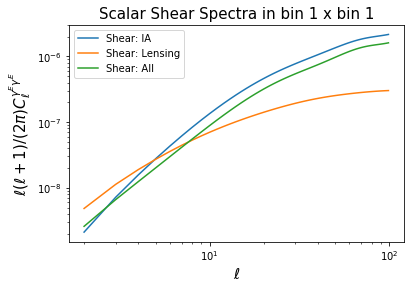

In [22]:
bin1 = 0
bin2 = 0
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Scalar Shear Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gEgE_scalar_IA[bin1,bin2],label='Shear: IA')
plt.plot(l_arr,pref*Cl_gEgE_scalar_lens[bin1,bin2],label='Shear: Lensing')
plt.plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Shear: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend();

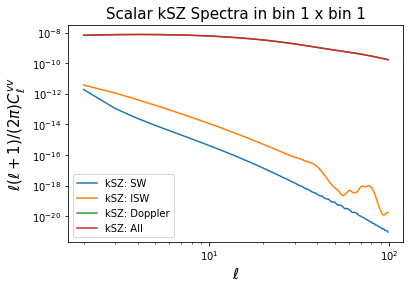

In [23]:
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Scalar kSZ Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_vv_scalar_SW[bin1,bin2],label='kSZ: SW')
plt.plot(l_arr,pref*Cl_vv_scalar_ISW[bin1,bin2],label='kSZ: ISW')
plt.plot(l_arr,pref*Cl_vv_scalar_Doppler[bin1,bin2],label='kSZ: Doppler')
plt.plot(l_arr,pref*Cl_vv_scalar_tot[bin1,bin2],label='kSZ: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{vv}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend();

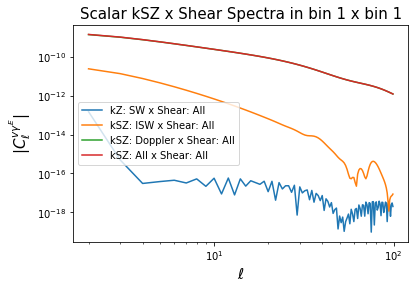

In [24]:
bin1 = 0
bin2 = 0
plt.title('Scalar kSZ x Shear Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,np.abs(Cl_vgE_scalar_SW[bin1,bin2]),label='kZ: SW x Shear: All')
plt.plot(l_arr,np.abs(Cl_vgE_scalar_ISW[bin1,bin2]),label='kSZ: ISW x Shear: All')
plt.plot(l_arr,np.abs(Cl_vgE_scalar_Doppler[bin1,bin2]),label='kSZ: Doppler x Shear: All')
plt.plot(l_arr,np.abs(Cl_vgE_scalar_tot[bin1,bin2]),label='kSZ: All x Shear: All')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$|C_\ell^{v\gamma^E}|$',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.legend();

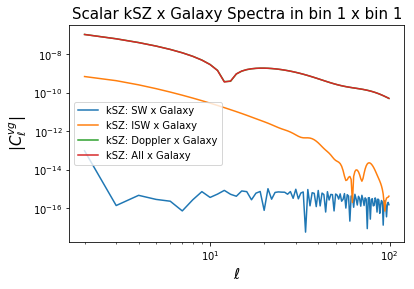

In [25]:
bin1 = 0
bin2 = 0
plt.title('Scalar kSZ x Galaxy Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,np.abs(Cl_vg_scalar_SW[bin1,bin2]),label='kSZ: SW x Galaxy')
plt.plot(l_arr,np.abs(Cl_vg_scalar_ISW[bin1,bin2]),label='kSZ: ISW x Galaxy')
plt.plot(l_arr,np.abs(Cl_vg_scalar_Doppler[bin1,bin2]),label='kSZ: Doppler x Galaxy')
plt.plot(l_arr,np.abs(Cl_vg_scalar_tot[bin1,bin2]),label='kSZ: All x Galaxy')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$|C_\ell^{vg}|$',fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.legend();

In [26]:
def compute_scalar_spectra(kernel1, kernel2, kmax):
    """Compute the full (non-Limber) scalar spectra given two kernels, using the dimensionless power spectrum of Psi."""
    
    Cl_out = np.zeros((n_tomo,n_tomo,len(l_arr)))

    for l_i in range(len(l_arr)):
        for i in range(n_tomo):
            for j in range(n_tomo):
                Cl_out[i,j,l_i] = 4.*np.pi*simps((k_arr<=kmax)*1./k_arr*kernel1[l_i,i]*np.conj(kernel2[l_i,j])*calP_Psi_arr,k_arr).real

    return Cl_out    

kmaxs = np.geomspace(0.5*H0,5000*H0,50)
vv_spec = np.asarray([compute_scalar_spectra(ksz_kernels_scalar[:,3],ksz_kernels_scalar[:,3],kk) for kk in kmaxs])
vg_spec = np.asarray([compute_scalar_spectra(ksz_kernels_scalar[:,3],gal_kernels_scalar[:],kk) for kk in kmaxs])
vgE_spec = np.asarray([compute_scalar_spectra(ksz_kernels_scalar[:,3],shear_kernels_scalar[:,2],kk) for kk in kmaxs])

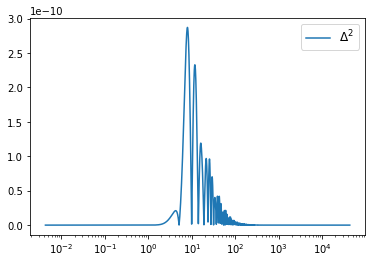

In [28]:
#plt.plot(k_arr/H0,np.abs(ksz_kernels_scalar[0,3,2])**2,label=r'$\Delta^2$')
#plt.plot(k_arr/H0,calP_Psi_arr*np.abs(ksz_kernels_scalar[0,3,2])**2,label=r'$\Delta^2$')
plt.plot(k_arr/H0,calP_Psi_arr*np.abs(ksz_kernels_scalar[1,3,2]*shear_kernels_scalar[1,2,2]),label=r'$\Delta^2$')
plt.legend(fontsize=12)
plt.xscale('log')

Text(0.5,1,'kSZ-shear')

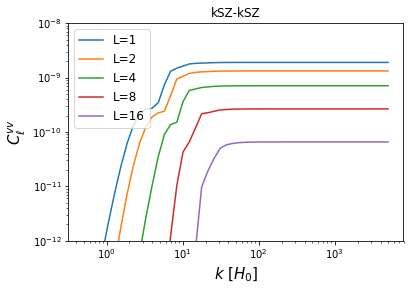

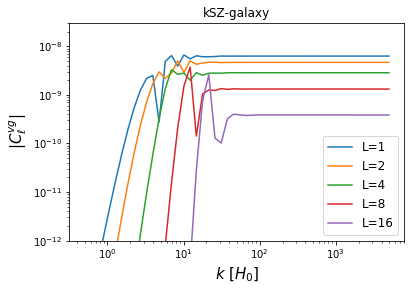

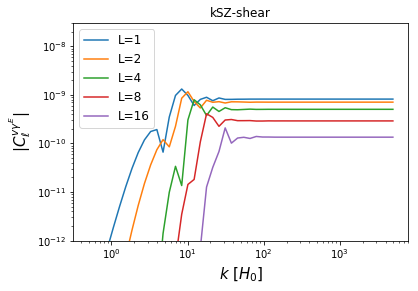

In [29]:
plt.plot(kmaxs/H0,vv_spec[:,2,2,0],label='L=1')
plt.plot(kmaxs/H0,vv_spec[:,2,2,1],label='L=2')
plt.plot(kmaxs/H0,vv_spec[:,2,2,3],label='L=4')
plt.plot(kmaxs/H0,vv_spec[:,2,2,7],label='L=8')
plt.plot(kmaxs/H0,vv_spec[:,2,2,15],label='L=16')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$H_0$]',fontsize=15)
plt.ylabel(r'$C_\ell^{vv}$',fontsize=15)
plt.ylim(1e-12,1e-8);
plt.legend(fontsize=12)
plt.title('kSZ-kSZ')

plt.figure()
plt.plot(kmaxs/H0,np.abs(vg_spec[:,2,2,0]),label='L=1')
plt.plot(kmaxs/H0,np.abs(vg_spec[:,2,2,1]),label='L=2')
plt.plot(kmaxs/H0,np.abs(vg_spec[:,2,2,3]),label='L=4')
plt.plot(kmaxs/H0,np.abs(vg_spec[:,2,2,7]),label='L=8')
plt.plot(kmaxs/H0,np.abs(vg_spec[:,2,2,15]),label='L=16')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$H_0$]',fontsize=15)
plt.ylabel(r'$|C_\ell^{vg}|$',fontsize=15)
plt.ylim(1e-12,3e-8);
plt.legend(fontsize=12)
plt.title('kSZ-galaxy')

plt.figure()
plt.plot(kmaxs/H0,np.abs(vgE_spec[:,2,2,0]),label='L=1')
plt.plot(kmaxs/H0,np.abs(vgE_spec[:,2,2,1]),label='L=2')
plt.plot(kmaxs/H0,np.abs(vgE_spec[:,2,2,3]),label='L=4')
plt.plot(kmaxs/H0,np.abs(vgE_spec[:,2,2,7]),label='L=8')
plt.plot(kmaxs/H0,np.abs(vgE_spec[:,2,2,15]),label='L=16')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [$H_0$]',fontsize=15)
plt.ylabel(r'$|C_\ell^{v\gamma^E}|$',fontsize=15)
plt.ylim(1e-12,3e-8);
plt.legend(fontsize=12)
plt.title('kSZ-shear')

## Shear and Galaxy Noise Spectra

In [30]:
# if opt_errors, increase nbar by a factor 2.5 and use Delta T_CMB = 0.5 muK-arcmin, theta_FWHM = 0.25 arcmin, as appropriate for CMB-HD
opt_errors = False

In [31]:
# Shear noise
# NB: same number density in each bin!
Cl_gg_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
Cl_gEgE_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
Cl_gBgB_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))
for i in range(n_tomo):
    if opt_errors:
        this_n = n_av[i]*2.5
    else:
        this_n = n_av[i]
    Cl_gg_noise[i,i] = 1./this_n*(1.+0.*l_arr)
    Cl_gEgE_noise[i,i] = sigma_gamma**2./this_n*(1.+0.*l_arr)
    Cl_gBgB_noise[i,i] = sigma_gamma**2./this_n*(1.+0.*l_arr)

### Plot Shear and Galaxy Spectra including noise

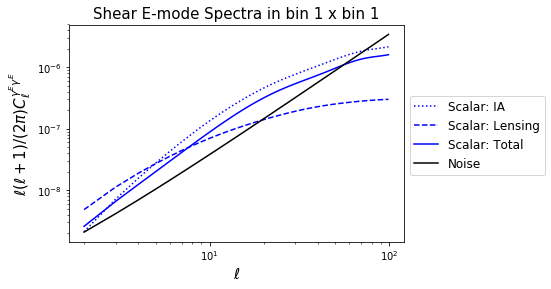

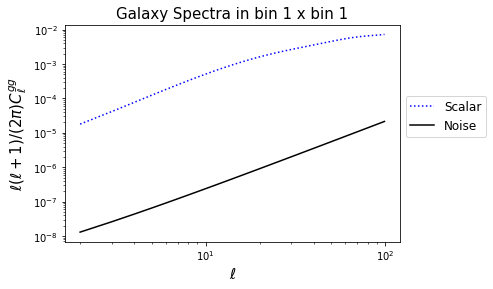

In [32]:
bin1 = 0
bin2 = 0
pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Shear E-mode Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gEgE_scalar_IA[bin1,bin2],label='Scalar: IA',c='b',ls=':')
plt.plot(l_arr,pref*Cl_gEgE_scalar_lens[bin1,bin2],label='Scalar: Lensing',c='b',ls='--')
plt.plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.plot(l_arr,pref*Cl_gEgE_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('Galaxy Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(l_arr,pref*Cl_gg_scalar[bin1,bin2],label='Scalar',c='b',ls=':')
plt.plot(l_arr,pref*Cl_gg_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{gg}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

## kSZ Noise Spectra

##### 1) CMB Spectra

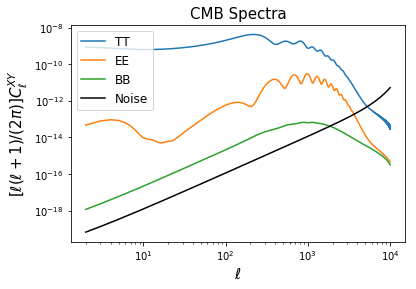

In [33]:
# l array for high-l 
highl_arr = np.geomspace(1,1e4,100)

# Lensed CMB spectra
cl = cc.lensed_cl(10000)
ll = cl['ell'][2:]
clTT = cl['tt'][2:]
clEE = cl['ee'][2:]
clBB = cl['bb'][2:]

# CMB Noise spectra
def Nl_CMB(deltaT, thetaFWHM):
    amp = 1e-6*deltaT/60.*np.pi/180./T_cmb # in radians
    fwhm = thetaFWHM/60.*np.pi/180. # in radians
    return amp**2*np.exp(ll*(ll+1.)*fwhm**2./(8.*np.log(2.)))

thetaFWHM = 1. # in arcmin
deltaPol = 1. # in microK-arcmin
if opt_errors:
    deltaPol = 0.5
    thetaFWHM = 0.25
T_cmb = cc.T_cmb()

# Plot CMB spectra
# NB: plotting in dimensionless units always
plt.plot(ll,ll*(ll+1.)*clTT,label='TT')
plt.plot(ll,ll*(ll+1.)*clEE,label='EE')
plt.plot(ll,ll*(ll+1.)*clBB,label='BB')
plt.plot(ll,ll*(ll+1.)*Nl_CMB(deltaPol,thetaFWHM),label='Noise',c='k')
plt.yscale('log')
plt.legend(fontsize=12)
plt.title("CMB Spectra",fontsize=15)
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$[\ell(\ell+1)/(2\pi)]C_\ell^{XY}$',fontsize=15);
plt.xscale('log')

ClTT = InterpolatedUnivariateSpline(ll,clTT+Nl_CMB(deltaPol,thetaFWHM))(highl_arr)
del clEE, clBB, clTT

##### 2) Galaxy Spectra

In [34]:
# Thomson cross section
sigmaT = 6.6524587321e-29*(3.24078e-23)**2 # in Mpc^2

# Current baryon density
cchi = cc.get_background()['comov. dist.']
crho_b = cc.get_background()['(.)rho_b']
# in 1/Mpc^2
rho_b_chi = InterpolatedUnivariateSpline(cchi[::-1],crho_b[::-1])
    
# Conversion factors (from CLASS)   
GeV_over_kg = 1.78266191e-27
Mpc_over_GeV = 1.56373832e38
Mpc_over_m = 3.086e+22
GeVcm3_over_Mpc2 = 94.7024726

print("Current baryon density: %.2e g/cm^3"%(rho_b_chi(0.)*GeVcm3_over_Mpc2*GeV_over_kg*1000.))

# Constants
sigmaT = 6.6524616e-29/Mpc_over_m**2. # in Mpc^2
m_proton = 1.672621637e-27/GeV_over_kg # in GeV

# Assume electron density = hydrogen + helium * baryons, assuming mostly ionized
n_e_chi = lambda chi: (0.75+0.25/2.)*rho_b_chi(chi)/m_proton*1e6*GeVcm3_over_Mpc2*Mpc_over_m**3. # in 1/Mpc^3
print("Current electron number density: %.2e cm^-3"%(n_e_chi(0.)/1e6/Mpc_over_m**3.))

Current baryon density: 4.51e-31 g/cm^3
Current electron number density: 2.36e-07 cm^-3


In [35]:
# Power spectra
calP_m_arr = (k_arr**3.)/(2.*np.pi**2.)*Pk_delta_z0(k_arr)

# Galaxy spectra
Cl_gal_gal = np.zeros((n_tomo,n_tomo,len(highl_arr)))

# Galaxy-tau spectra
Cl_tau_gal = np.zeros((n_tomo,n_tomo,len(highl_arr)))

Dz_func = InterpolatedUnivariateSpline(chi_arr,Dz_arr,ext='zeros')
a_func = InterpolatedUnivariateSpline(chi_arr,a_arr,ext='zeros')
bz_arr = 0.95/Dz_arr
bz_func = InterpolatedUnivariateSpline(chi_arr,bz_arr,ext='zeros')
n_funcs = [InterpolatedUnivariateSpline(chi_arr,n_chis[i],ext='zeros') for i in range(n_tomo)]

for l_i,l in enumerate(highl_arr):
    
    # Compute in Limber approximation
    chis = (l+0.5)/k_arr
    for i in range(n_tomo):
        if opt_errors:
            this_n = n_av[i]*2.5
        else:
            this_n = n_av[i]
        Cl_gal_gal[i,i,l_i] = simps(n_funcs[i](chis)**2*bz_func(chis)**2.*Dz_func(chis)**2.*Pk_delta_z0(k_arr)/(l+0.5),k_arr)+1./this_n
        Cl_tau_gal[i,i,l_i] = sigmaT*simps(a_func(chis)*n_e_chi(chis)*n_funcs[i](chis)*bz_func(chis)*Dz_func(chis)**2.*Pk_delta_z0(k_arr)/(l+0.5),k_arr)

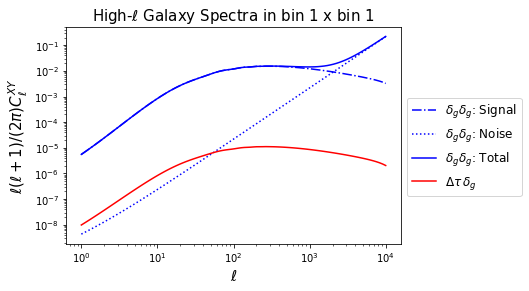

In [36]:
bin1 = 0
bin2 = 0
pref = highl_arr*(highl_arr+1.)/(2.*np.pi)
this_n = n_av[bin1]*(1.+1.5*opt_errors)
plt.title(r'High-$\ell$ Galaxy Spectra in bin %d x bin %d'%(bin1+1,bin2+1),fontsize=15)
plt.plot(highl_arr,pref*(Cl_gal_gal[bin1,bin2]-(bin1==bin2)/this_n),label=r'$\delta_g\delta_g$: Signal',c='b',ls='-.')
plt.plot(highl_arr,pref*(1./this_n)*(bin1==bin2),label=r'$\delta_g\delta_g$: Noise',c='b',ls=':')
plt.plot(highl_arr,pref*Cl_gal_gal[bin1,bin2],label=r'$\delta_g\delta_g$: Total',c='b')
plt.plot(highl_arr,pref*Cl_tau_gal[bin1,bin2],label=r'$\Delta\tau\,\delta_g$',c='r',ls='-');
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{XY}$',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

##### 3) Combination to noise spectrum

\begin{eqnarray}
    \Gamma_{\ell\ell_1\ell_2}^{\rm kSZ}(\chi) = \sqrt{\frac{(2\ell+1)(2\ell_1+1)(2\ell_2+1)}{4\pi}}\begin{pmatrix}\ell &\ell_1&\ell_2\\0&0&0\end{pmatrix}C_{\ell_2}^{\Delta \tau\delta_g}(\chi).
\end{eqnarray}

\begin{eqnarray}
\frac{1}{N_{\ell,ab}^{vv}} &=& \frac{\delta_{\rm K}^{ab}}{2\ell+1)}\sum_{\ell_1\ell_2}\frac{\Gamma_{\ell\ell_1\ell_2,a}^{\rm kSZ}\Gamma_{\ell\ell_1\ell_2,b}^{\rm kSZ}}{C_{\ell_1}^{TT}C_{\ell_2,ab}^{\delta_g\delta_g}}\end{eqnarray}

We precompute all $3j$ symbols with https://github.com/xzackli/WignerFamilies.jl in Julia. This calculation is implemented in the accompanying notebook.

In [37]:
tj_arr = np.load('/projects/QUIJOTE/Oliver/wig3j_array_ksz.npz')

In [38]:
# Interpolators for spectra at high-l
ClTT_func = InterpolatedUnivariateSpline(highl_arr,ClTT)
Clgg_func = [InterpolatedUnivariateSpline(highl_arr,Cl_gal_gal[bin1,bin1]) for bin1 in range(n_tomo)]
Cltaug_func = [InterpolatedUnivariateSpline(highl_arr,Cl_tau_gal[bin1,bin1]) for bin1 in range(n_tomo)]

Cl_vv_noise = np.zeros((n_tomo,n_tomo,len(l_arr)))

# Create arrays of Cls for speed
min_l = 1
max_l = 10000
clTs = [ClTT_func(l) for l in range(1,max_l+1)]

def Gamma_kSZ(l,l1,l2_arr,bin1):
    pref = np.sqrt((2.*l+1.)*(2.*l1+1.)*(2.*l2_arr+1.)/(4.*np.pi))
    tj = tj_arr[l-1,l1-1,:len(l2_arr)]
    spec = Cltaug_func[bin1](l2_arr)
    return pref*tj*spec

In [39]:
for bin1 in range(n_tomo):
    print("Computing kSZ noise-curve for bin %d of %d"%(bin1+1,n_tomo))
    for l_i in range(len(l_arr)):
        l = l_arr[l_i]
        sumv = 0.
        for l1 in range(min_l,max_l+1):
            # sum over all l2 in allowed range
            clT = clTs[l1-1]
            l2s = np.arange(max([l1-l,0]),min([l1+l,max_l])+1)
            GkSZ = Gamma_kSZ(l,l1,l2s,bin1)**2.
            clg = Clgg_func[bin1](l2s)
            sumv += np.sum(GkSZ/(clT*clg))
        Cl_vv_noise[bin1,bin1,l_i] = (2.*l+1.)/sumv

Computing kSZ noise-curve for bin 1 of 6
Computing kSZ noise-curve for bin 2 of 6
Computing kSZ noise-curve for bin 3 of 6
Computing kSZ noise-curve for bin 4 of 6
Computing kSZ noise-curve for bin 5 of 6
Computing kSZ noise-curve for bin 6 of 6


### Plot all contributions

In [40]:
shear_signal = False # whether to include scalar shear in the covariance
ksz_signal = False # whether to include scalar kSZ in the covariance

# Compute total spectra under null assumptions
Cl_gEgE = shear_signal*Cl_gEgE_scalar_tot+Cl_gEgE_noise
Cl_gEv = shear_signal*ksz_signal*Cl_gEv_scalar_tot

Cl_vgE = shear_signal*ksz_signal*Cl_vgE_scalar_tot
Cl_vv = ksz_signal*Cl_vv_scalar_tot+Cl_vv_noise

Cl_gg = Cl_gg_scalar+Cl_gg_noise
Cl_vg = ksz_signal*Cl_vg_scalar_tot
Cl_gv = ksz_signal*Cl_vg_scalar_tot.swapaxes(0,1)

Bins: 5 x 5


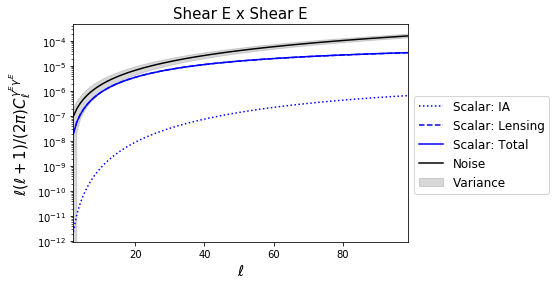

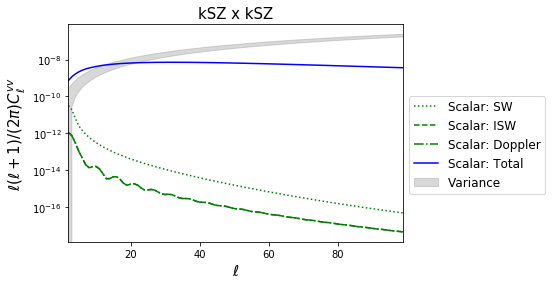

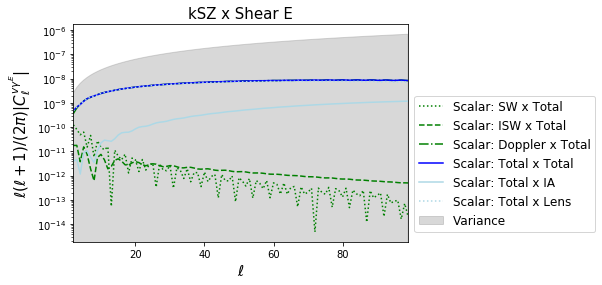

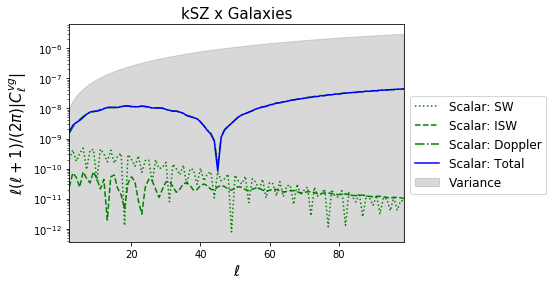

In [41]:
bin1 = 4
bin2 = 4
dl = np.diff(l_arr).mean()
print("Bins: %d x %d"%(bin1+1,bin2+1))

pref = l_arr*(l_arr+1.)/(2.*np.pi)
plt.title('Shear E x Shear E',fontsize=15)
Cl_err = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_gEgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_gEgE[bin1,bin1]-Cl_err),pref*(Cl_gEgE[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*Cl_gEgE_scalar_IA[bin1,bin2],label='Scalar: IA',c='b',ls=':')
plt.plot(l_arr,pref*Cl_gEgE_scalar_lens[bin1,bin2],label='Scalar: Lensing',c='b',ls='--')
plt.plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.plot(l_arr,pref*Cl_gEgE_noise[bin1,bin2],label='Noise',c='k')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{\gamma^E\gamma^E}$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('kSZ x kSZ',fontsize=15)
Cl_err = np.sqrt((Cl_vv[bin1,bin1]*Cl_vv[bin2,bin2]+Cl_vv[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_vv[bin1,bin1]-Cl_err),pref*(Cl_vv[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*Cl_vv_scalar_SW[bin1,bin2],label='Scalar: SW',c='g',ls=':')
plt.plot(l_arr,pref*Cl_vv_scalar_ISW[bin1,bin2],label='Scalar: ISW',c='g',ls='--')
plt.plot(l_arr,pref*Cl_vv_scalar_ISW[bin1,bin2],label='Scalar: Doppler',c='g',ls='-.')
plt.plot(l_arr,pref*Cl_vv_scalar_tot[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)C_\ell^{vv}$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('kSZ x Shear E',fontsize=15)
Cl_err = np.sqrt((Cl_vv[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_vgE[bin1,bin2]**2)/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_vgE[bin1,bin1]-Cl_err),pref*(Cl_vgE[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_vgE_scalar_SW)[bin1,bin2],label='Scalar: SW x Total',c='g',ls=':')
plt.plot(l_arr,pref*np.abs(Cl_vgE_scalar_ISW)[bin1,bin2],label='Scalar: ISW x Total',c='g',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_vgE_scalar_Doppler)[bin1,bin2],label='Scalar: Doppler x Total',c='g',ls='-.')
plt.plot(l_arr,pref*np.abs(Cl_vgE_scalar_tot)[bin1,bin2],label='Scalar: Total x Total',c='b',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_vgE_scalar_IA)[bin1,bin2],label='Scalar: Total x IA',c='lightblue',ls='-')
plt.plot(l_arr,pref*np.abs(Cl_vgE_scalar_lens)[bin1,bin2],label='Scalar: Total x Lens',c='lightblue',ls=':')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{v\gamma^E}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

plt.figure()
plt.title('kSZ x Galaxies',fontsize=15)
Cl_err = np.sqrt((Cl_vv[bin1,bin1]*Cl_gg[bin2,bin2]+Cl_vg[bin1,bin2]*Cl_gv[bin1,bin2])/(f_sky*dl*(2.*l_arr+1.)))
plt.fill_between(l_arr,pref*(Cl_vg[bin1,bin1]-Cl_err),pref*(Cl_vg[bin1,bin1]+Cl_err),label='Variance',color='gray',alpha=0.3)
plt.plot(l_arr,pref*np.abs(Cl_vg_scalar_SW)[bin1,bin2],label='Scalar: SW',c='g',ls=':')
plt.plot(l_arr,pref*np.abs(Cl_vg_scalar_ISW)[bin1,bin2],label='Scalar: ISW',c='g',ls='--')
plt.plot(l_arr,pref*np.abs(Cl_vg_scalar_Doppler)[bin1,bin2],label='Scalar: Doppler',c='g',ls='-.')
plt.plot(l_arr,pref*np.abs(Cl_vg_scalar_tot)[bin1,bin2],label='Scalar: Total',c='b',ls='-')
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\ell(\ell+1)/(2\pi)\left|C_\ell^{vg}\right|$',fontsize=15)
plt.yscale('log')
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=12,bbox_to_anchor=(1.,0.7));

## Paper Plots
- Plot the main auto- and cross-spectra for a single redshift bin.
- Spectra are shown in $\mu K^2$ units, multiplied by $\ell(\ell+1)/(2\pi)$
- We plot errors both for a realistic case with VRO galaxy densities and $1\mu K$-arcmin noise, and the most optimistic case, with zero CMB and galaxy survey noise.
- Note that we run the above code twice: once with fiducial and once with optimistic errors (switching on the ```opt_errors``` flag)

In [42]:
bin1 = 2
bin2 = 2
if opt_errors:
    this_f_sky = 0.5
    gEgEOp = Cl_gEgE[bin1,bin1]
    vvOp = Cl_vv[bin1,bin1]
    gEgE_noiseOp = Cl_gEgE_noise[bin1,bin1]
    vv_noiseOp = Cl_vv_noise[bin1,bin1]
    gEgE_errOp = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_gEgE[bin1,bin2]**2)/(this_f_sky*dl*(2.*l_arr+1.)))
    vv_errOp = np.sqrt((Cl_vv[bin1,bin1]*Cl_vv[bin2,bin2]+Cl_vv[bin1,bin2]**2)/(this_f_sky*dl*(2.*l_arr+1.)))
    vgE_errOp = np.sqrt((Cl_vv[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_vgE[bin1,bin2]**2)/(this_f_sky*dl*(2.*l_arr+1.)))
else:
    this_f_sky = f_sky
    gEgE = Cl_gEgE[bin1,bin1]
    vv = Cl_vv[bin1,bin1]
    gEgE_noise = Cl_gEgE_noise[bin1,bin1]
    vv_noise = Cl_vv_noise[bin1,bin1]
    gEgE_err = np.sqrt((Cl_gEgE[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_gEgE[bin1,bin2]**2)/(this_f_sky*dl*(2.*l_arr+1.)))
    vv_err = np.sqrt((Cl_vv[bin1,bin1]*Cl_vv[bin2,bin2]+Cl_vv[bin1,bin2]**2)/(this_f_sky*dl*(2.*l_arr+1.)))
    vgE_err = np.sqrt((Cl_vv[bin1,bin1]*Cl_gEgE[bin2,bin2]+Cl_vgE[bin1,bin2]**2)/(this_f_sky*dl*(2.*l_arr+1.)))

Bins: 3 x 3
Average z = 1.2


NameError: name 'gEgEOp' is not defined

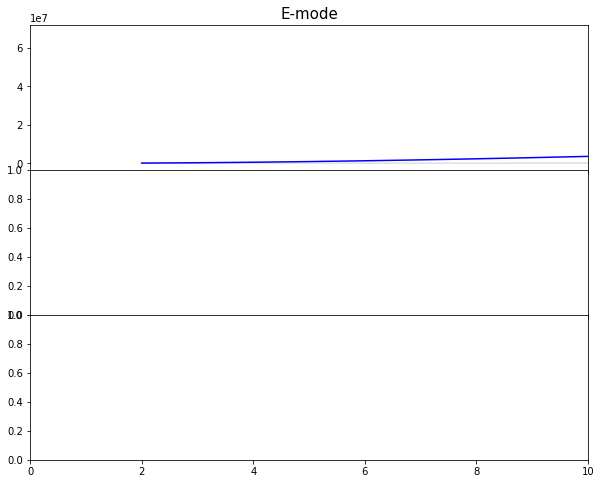

In [43]:
dl = np.diff(l_arr).mean()
print("Bins: %d x %d"%(bin1+1,bin2+1))
print(r'Average z = %.1f'%simps(n_chis[bin1]*z_arr,chi_arr))

fig,ax=plt.subplots(3,1,sharex=True,figsize=(10,8))
plt.subplots_adjust(hspace=0,wspace=0)
plt.xlim([0,10])

pref = l_arr*(l_arr+1.)/(2.*np.pi)*T_cmb**2.*1e12
ax[0].set_title('E-mode',fontsize=15)

rT_rescale = 1./rT_fid
a1 = 0.2
a2 = 0.6
lw = 1.

# gEgE
ax[0].plot(l_arr,pref*Cl_gEgE_scalar_tot[bin1,bin2],c='b',ls='-')
ax[0].fill_between(l_arr,pref*(gEgE-gEgE_err),pref*(gEgE+gEgE_err),color='gray',alpha=a1)
ax[0].fill_between(l_arr,pref*(gEgEOp-gEgE_errOp),pref*(gEgEOp+gEgE_errOp),color='gray',alpha=a2)
ax[0].plot(l_arr,pref*gEgE_noise,c='k',lw=lw)
ax[0].plot(l_arr,pref*gEgE_noiseOp,c='k',lw=lw,ls='--')

# vv
ax[1].plot(l_arr,pref*Cl_vv_scalar_tot[bin1,bin2],c='b',ls='-')
ax[1].fill_between(l_arr,pref*(vv-vv_err),pref*(vv+vv_err),color='gray',alpha=a1)
ax[1].fill_between(l_arr,pref*(vvOp-vv_errOp),pref*(vvOp+vv_errOp),color='gray',alpha=a2)
ax[1].plot(l_arr,pref*vv_noise,c='k',lw=lw)
ax[1].plot(l_arr,pref*vv_noiseOp,c='k',lw=lw,ls='--')

# vgE
ax[2].plot(l_arr,pref*np.abs(Cl_vgE_scalar_tot[bin1,bin2]),c='b',ls='-')
ax[2].fill_between(l_arr,pref*(Cl_vgE[bin1,bin1]-vgE_err),pref*(Cl_vgE[bin1,bin1]+vgE_err),color='gray',alpha=a1)
ax[2].fill_between(l_arr,pref*(Cl_vgE[bin1,bin1]-vgE_errOp),pref*(Cl_vgE[bin1,bin1]+vgE_errOp),color='gray',alpha=a2)

ax[2].fill_between(l_arr,pref*0.,pref*0.,
                     label='Variance [CMB-S4 / VRO]',color='gray',alpha=a1)
ax[2].fill_between(l_arr,pref*0.,pref*0.,
                     label='Variance [CMB-HD / VRO]',color='gray',alpha=a2)
ax[2].plot(l_arr,0.*l_arr,color='b',ls='-',label='Scalar')
ax[2].plot(l_arr,pref*0.,label='Noise [CMB-S4 / VRO]',c='k',lw=lw)
ax[2].plot(l_arr,pref*0.,c='k',label='Noise [CMB-HD / VRO]',lw=lw,ls='--')

ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'Shear x Shear',fontsize=15)
ax[1].set_ylabel(r'kSZ x kSZ',fontsize=15)
ax[2].set_ylabel(r'kSZ x Shear',fontsize=15)
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].set_yscale('log')
ax[0].tick_params(axis='x', labelsize=12)
ax[0].set_ylim([1e1,1e9])
ax[1].set_ylim([1e1,9e5])
ax[2].set_ylim([1e2,9e5])
ax[0].set_xlim([min(l_arr),39])
ax[0].set_xlim([min(l_arr),39])
ax[0].set_xticks([2,10,20,30])
ax[2].legend(fontsize=12,fancybox=True,shadow=True,ncol=1,bbox_to_anchor=(1.,1.));
#fig.savefig('figs/kSZ_plot.pdf',bbox_inches='tight')

In [ ]:
binA = 1
binB = 5
dl = np.diff(l_arr).mean()

fig,ax=plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,4))
plt.subplots_adjust(hspace=0,wspace=0)
plt.xlim([0,10])

pref = l_arr*(l_arr+1.)/(2.*np.pi)*T_cmb**2.*1e12

ax[0].set_title(r'$\bar z = %.1f$'%simps(n_chis[binA]*z_arr,chi_arr),fontsize=15)
ax[1].set_title(r'$\bar z = %.1f$'%simps(n_chis[binB]*z_arr,chi_arr),fontsize=15)

rT_rescale = 10
a1 = 0.2
lw = 1.

for i,bin1,bin2 in zip(range(2),[binA,binB],[binA,binB]):
    
    # full shear
    ax[i].plot(l_arr,pref*np.abs(Cl_vgE_scalar_SW[bin1,bin2]),c='g',ls='-',label='SW')
    ax[i].plot(l_arr,pref*np.abs(Cl_vgE_scalar_ISW[bin1,bin2]),c='r',ls='-',label='ISW')
    ax[i].plot(l_arr,pref*np.abs(Cl_vgE_scalar_Doppler[bin1,bin2]),c='b',ls='-',label='Doppler')

    # lensing-only
    ax[i].plot(l_arr,pref*np.abs(Cl_vgE_scalar_SW[bin1,bin2]),c='g',ls=':')
    ax[i].plot(l_arr,pref*np.abs(Cl_vgE_scalar_ISW_lens[bin1,bin2]),c='r',ls=':')
    ax[i].plot(l_arr,pref*np.abs(Cl_vgE_scalar_Doppler_lens[bin1,bin2]),c='b',ls=':')

    # errors
    ax[i].fill_between(l_arr,pref*(Cl_vgE[bin1,bin1]-vgE_err),pref*(Cl_vgE[bin1,bin1]+vgE_err),color='gray',alpha=a1)
    
ax[0].set_xlabel(r'$\ell$',fontsize=15)
ax[0].set_ylabel(r'$\frac{\ell(\ell+1)}{2\pi}\left|C_\ell^{v\gamma^E}\right|$ [$\mu K^2$]',fontsize=15)
ax[1].set_yscale('log')
ax[0].tick_params(axis='y', labelsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)

ax[0].set_xlim([2,39])
ax[0].set_ylim([1e-4,1e6])
ax[1].set_yticks([])
ax[1].set_yticks([],minor=True)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xticks([2,5,10,20,30])
ax[1].set_xticks([2,5,10,20,30])
ax[0].set_xticklabels([2,5,10,20,30])
ax[1].set_xticklabels([2,5,10,20,30])
ax[0].legend(fontsize=13,fancybox=True,shadow=True,ncol=1,bbox_to_anchor=(2.45,0.7));
if not opt_errors: fig.savefig('figs/contributions_vg.pdf',bbox_inches='tight')

# Fisher Forecasts

Below we forecast the S/N of the following quantities:
- kSZ auto-spectra
- kSZ x lensing cross-spectra
- Detectability of ISW effect
- Detectability of SW effect
- Detectability of Doppler effect

- It is also interesting to forecast dependence on the z-binning and CMB / galaxy noise parameters.

In [299]:
if opt_errors:
    this_f_sky = 0.5
else:
    this_f_sky = 0.36

# Construct matrix of all spectra
Cls = np.asarray([[Cl_gEgE,Cl_gEv,0.*Cl_vg], # gE
                  [Cl_vgE,Cl_vv,Cl_vg], # v
                  [0.*Cl_gv,Cl_gv,Cl_gg]]) # g

def cross_covariance_factor(X,Y,Z,W,a,b,c,d):
    """X etc. are {0,1,2} for {gE, v, g}
    a etc. are bin indices"""
    out = Cls[X,Z][a,c]*Cls[Y,W][b,d]+Cls[X,W][a,d]*Cls[Y,Z][b,c]
    return out

# Construct cross-covariance matrix for any ell and all shear + kSZ statistics
cross_covariances_all = np.zeros((n_tomo*(n_tomo+1)*2-n_tomo,n_tomo*(n_tomo+1)*2-n_tomo,len(l_arr)))
ii = 0
dl = np.diff(l_arr).mean()
assert(np.diff(l_arr).var()<1e-10)
for X,Y in [[0,0],[0,1],[1,0],[1,1]]:
    #        gEgE, gEv, vgE, vv 
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[0,0],[0,1],[1,0],[1,1]]:
                #        gEgE, gEv, vgE, vv 
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_all[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(this_f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1

# Construct cross-covariance matrix for any ell and cross shear-kSZ statistics
cross_covariances_cross = np.zeros((n_tomo*(n_tomo+1)-n_tomo,n_tomo*(n_tomo+1)-n_tomo,len(l_arr)))
ii = 0
dl = np.diff(l_arr).mean()
assert(np.diff(l_arr).var()<1e-10)
for X,Y in [[0,1],[1,0]]:
    #        gEv, vgE
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[0,1],[1,0]]:
                #        gEv, vgE 
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_cross[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(this_f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and shear-only statistics
cross_covariances_g = np.zeros((n_tomo*(n_tomo+1)/2,n_tomo*(n_tomo+1)/2,len(l_arr)))
ii = 0
for X,Y in [[0,0]]:
    # gEgE
    for a in range(n_tomo):
        for b in range(a,n_tomo):
            jj = 0
            for Z,W in [[0,0]]:
                # gEgE
                for c in range(n_tomo):
                    for d in range(c,n_tomo):
                        cross_covariances_g[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(this_f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and kSZ-only statistics
cross_covariances_q = np.zeros((n_tomo*(n_tomo+1)/2,n_tomo*(n_tomo+1)/2,len(l_arr)))
ii = 0
for X,Y in [[1,1]]:
    # vv
    for a in range(n_tomo):
        for b in range(a,n_tomo):
            jj = 0
            for Z,W in [[1,1]]:
                # vv
                for c in range(n_tomo):
                    for d in range(c,n_tomo):
                        cross_covariances_q[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(this_f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1
            
# Construct cross-covariance matrix for any ell and gal/kSZ statistics
cross_covariances_gal = np.zeros((n_tomo**2,n_tomo**2,len(l_arr)))
ii = 0
for X,Y in [[1,2],[2,1]]:
    # vg, gv
    for a in range(n_tomo):
        if X<=Y: 
            b_min = a
        else:
            # skip a = b element for cross-spectra if already included!
            b_min = a+1
        for b in range(b_min,n_tomo):
            jj = 0
            for Z,W in [[1,2],[2,1]]:
                # vg, gv
                for c in range(n_tomo):
                    if Z<=W:
                        d_min = c
                    else:
                        # skip c = d element for cross-spectra if already included!
                        d_min = c+1
                    for d in range(d_min,n_tomo):
                        cross_covariances_gal[ii,jj] = cross_covariance_factor(X,Y,Z,W,a,b,c,d)/(this_f_sky*dl*(2.*l_arr+1.))
                        jj += 1
            ii += 1

In [300]:
def compute_fisher_shear(signal,fid_val=1.):
    """Compute Fisher matrix from shear for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [gEgE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_g[:,:,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)/2)

        # Assemble matrices
        ii = 0
        for j in range(1):
            for a in range(n_tomo):
                for b in range(a,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_kSZ(signal,fid_val=1.):
    """Compute Fisher matrix from kSZ for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [vv]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_q[:,:,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)/2)

        # Assemble matrices
        ii = 0
        for j in range(1):
            for a in range(n_tomo):
                for b in range(a,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_cross(signal,fid_val=1.):
    """Compute Fisher matrix from shear x kSZ for a given input signal vector (without auto-spectra).
    
    The derivative vector is the desired signal in the following configurations: [gEv, vgE]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_cross[:,:,l_i]
        Sl_vec = np.zeros(n_tomo**2)

        # Assemble matrices
        ii = 0
        for j in range(2):
            # skip i=j bin if already counted
            if j==1:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher_gal_cross(signal,fid_val=1.):
    """Compute Fisher matrix from galaxies x kSZ for a given input signal vector (without auto-spectra).
    
    The derivative vector is the desired signal in the following configurations: [vg, gv]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_gal[:,:,l_i]
        Sl_vec = np.zeros(n_tomo**2)
        
        # Assemble matrices
        ii = 0
        for j in range(2):
            # skip i=j bin if already counted
            if j==1:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

def compute_fisher(signal,fid_val=1.):
    """Compute Fisher matrix from shear and kSZ for a given input signal vector.
    
    The derivative vector is the desired signal in the following configurations: [gEgE, gEv, vgE, vv]
    
    """
    fish = 0.
    fish_ell = []
    
    # Compute Fisher matrix
    for l_i in range(len(l_arr)):
        Cl_mat = cross_covariances_all[:,:,l_i]
        Sl_vec = np.zeros(n_tomo*(n_tomo+1)*2-n_tomo)

        # Assemble matrices
        ii = 0
        for j in range(4):
            # skip i=j bin if already counted
            if j==1 or j==2:
                delta_b = 1
            else:
                delta_b = 0
            for a in range(n_tomo):
                for b in range(a+delta_b,n_tomo):
                    if type(signal[j])==np.float64 or type(signal[j])==int:
                        Sl_vec[ii] = 0.
                    else:
                        Sl_vec[ii] = signal[j][a,b,l_i]
                    ii += 1
                    
        # Assemble Fisher matrix combination (for uncorrelated l-bins)
        invC = np.linalg.inv(Cl_mat)
        fish_l = np.inner(Sl_vec,np.inner(invC,Sl_vec))
        fish += fish_l
        fish_ell.append(fish_l)
    fish_ell = np.asarray(fish_ell)
    print('1-sigma bound: %.4f, Fiducial: %.2e, S/N: %.3f'%(1./np.sqrt(fish),fid_val,np.sqrt(fish)*fid_val))
    return fish_ell

### Scalar S/N forecasts
- Here, we simply compute the S/N of the various spectra, i.e. writing $C_\ell^{XY}\to\alpha\,C_\ell^{XY}$ and forecasting the constraints on $\alpha$ as a function of $\ell$.

In [301]:
assert(shear_signal==False)
assert(ksz_signal==False)

print("shear lens")
fish_gg_lens=compute_fisher_shear([Cl_gEgE_scalar_lens],fid_val=1.)
print("shear IA")
fish_gg_IA=compute_fisher_shear([Cl_gEgE_scalar_IA],fid_val=1.)
print("shear total")
fish_gg_tot=compute_fisher_shear([Cl_gEgE_scalar_tot],fid_val=1.)

print("")
print("kSZ SW")
fish_vv_SW=compute_fisher_kSZ([Cl_vv_scalar_SW],fid_val=1.)
print("kSZ ISW")
fish_vv_ISW=compute_fisher_kSZ([Cl_vv_scalar_ISW],fid_val=1.)
print("kSZ Doppler")
fish_vv_Doppler=compute_fisher_kSZ([Cl_vv_scalar_Doppler],fid_val=1.)
print("kSZ total")
fish_vv_tot=compute_fisher_kSZ([Cl_vv_scalar_tot],fid_val=1.)

print("")
print("shear-cross total/lens")
fish_cross_tot_lens=compute_fisher_cross([np.swapaxes(Cl_vgE_scalar_lens,0,1),Cl_vgE_scalar_lens],fid_val=1.)
print("shear-cross total/IA")
fish_cross_tot_IA=compute_fisher_cross([np.swapaxes(Cl_vgE_scalar_IA,0,1),Cl_vgE_scalar_IA],fid_val=1.)
print("")
print("shear-cross SW/total")
fish_cross_tot_SW=compute_fisher_cross([np.swapaxes(Cl_vgE_scalar_SW,0,1),Cl_vgE_scalar_SW],fid_val=1.)
print("shear-cross ISW/total")
fish_cross_tot_ISW=compute_fisher_cross([np.swapaxes(Cl_vgE_scalar_ISW,0,1),Cl_vgE_scalar_ISW],fid_val=1.)
print("shear-cross Doppler/total")
fish_cross_tot_Doppler=compute_fisher_cross([np.swapaxes(Cl_vgE_scalar_Doppler,0,1),Cl_vgE_scalar_Doppler],fid_val=1.)
print("shear-cross total/total")
fish_cross_tot_tot=compute_fisher_cross([np.swapaxes(Cl_vgE_scalar_tot,0,1),Cl_vgE_scalar_tot],fid_val=1.)

print("")
print("gal-cross SW/total")
fish_gal_cross_tot_SW=compute_fisher_gal_cross([Cl_vg_scalar_SW,Cl_vg_scalar_SW.swapaxes(0,1)],fid_val=1.)
print("gal-cross ISW/total")
fish_gal_cross_tot_ISW=compute_fisher_gal_cross([Cl_vg_scalar_ISW,Cl_vg_scalar_ISW.swapaxes(0,1)],fid_val=1.)
print("gal-cross Doppler/total")
fish_gal_cross_tot_Doppler=compute_fisher_gal_cross([Cl_vg_scalar_Doppler,Cl_vg_scalar_Doppler.swapaxes(0,1)],fid_val=1.)
print("gal-cross total/total")
fish_gal_cross_tot_tot=compute_fisher_gal_cross([Cl_vg_scalar_tot,Cl_vg_scalar_tot.swapaxes(0,1)],fid_val=1.)

shear lens
1-sigma bound: 0.0015, Fiducial: 1.00e+00, S/N: 660.377
shear IA
1-sigma bound: 0.0176, Fiducial: 1.00e+00, S/N: 56.769
shear total
1-sigma bound: 0.0017, Fiducial: 1.00e+00, S/N: 592.494

kSZ SW
1-sigma bound: 0.0327, Fiducial: 1.00e+00, S/N: 30.620
kSZ ISW
1-sigma bound: 0.5607, Fiducial: 1.00e+00, S/N: 1.783
kSZ Doppler
1-sigma bound: 0.0018, Fiducial: 1.00e+00, S/N: 563.544
kSZ total
1-sigma bound: 0.0018, Fiducial: 1.00e+00, S/N: 562.642

shear-cross total/lens
1-sigma bound: 0.0133, Fiducial: 1.00e+00, S/N: 75.222
shear-cross total/IA
1-sigma bound: 0.0330, Fiducial: 1.00e+00, S/N: 30.305

shear-cross SW/total
1-sigma bound: 2.5898, Fiducial: 1.00e+00, S/N: 0.386
shear-cross ISW/total
1-sigma bound: 2.1329, Fiducial: 1.00e+00, S/N: 0.469
shear-cross Doppler/total
1-sigma bound: 0.0121, Fiducial: 1.00e+00, S/N: 82.438
shear-cross total/total
1-sigma bound: 0.0121, Fiducial: 1.00e+00, S/N: 82.602

gal-cross SW/total
1-sigma bound: 3.8168, Fiducial: 1.00e+00, S/N: 0.262
g

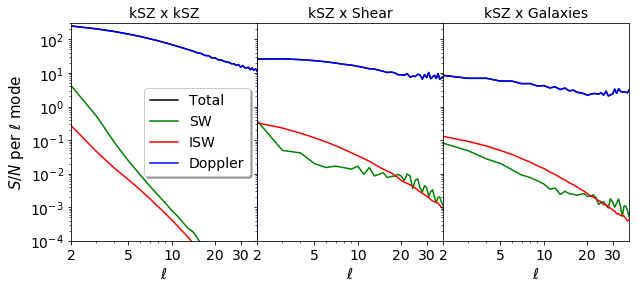

In [302]:
fig,ax = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(l_arr,np.sqrt(dl*fish_vv_tot),label='Total',c='k',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_vv_SW),label='SW',c='g',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_vv_ISW),label='ISW',c='r',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_vv_Doppler),label='Doppler',c='b',ls='-')
ax[0].set_title('kSZ x kSZ',fontsize=14)
ax[0].set_ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim([1e-4,300])
ax[0].tick_params(axis='y', labelsize=14)

ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_tot),label='Total',c='k',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_SW),label='SW',c='g',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_ISW),label='ISW',c='r',ls='-')
ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_Doppler),label='Doppler',c='b',ls='-')
ax[1].set_title('kSZ x Shear',fontsize=14)

ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_tot),label='Total',c='k',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_SW),label='SW',c='g',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_ISW),label='ISW',c='r',ls='-')
ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_Doppler),label='Doppler',c='b',ls='-')
ax[2].set_title('kSZ x Galaxies',fontsize=14)

ax[0].set_xlim([2,39])
for j in range(3):
    ax[j].set_xticklabels([2,5,10,20,30])
    ax[j].set_xticks([2,5,10,20,30])
    ax[j].set_xlabel(r'$\ell$',fontsize=15)
    ax[j].tick_params(axis='x', labelsize=14)

ax[0].legend(fontsize=14,fancybox=True,shadow=True,ncol=1)#,bbox_to_anchor=(3.65,0.7));
if not opt_errors: fig.savefig('figs/SN_scalar_ksz.pdf',bbox_inches='tight')

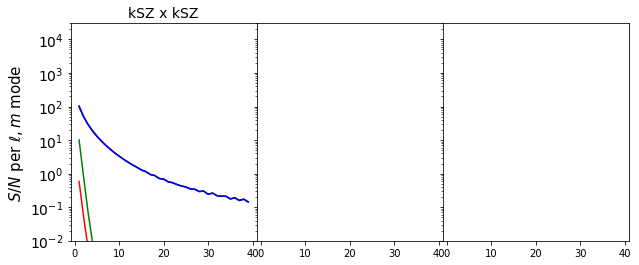

In [307]:
fig,ax = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)

ax[0].plot(l_arr,np.sqrt(dl*fish_vv_tot)/(2.*l_arr+1.),label='Total',c='k',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_vv_SW)/(2.*l_arr+1.),label='SW',c='g',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_vv_ISW)/(2.*l_arr+1.),label='ISW',c='r',ls='-')
ax[0].plot(l_arr,np.sqrt(dl*fish_vv_Doppler)/(2.*l_arr+1.),label='Doppler',c='b',ls='-')
ax[0].set_title('kSZ x kSZ',fontsize=14)
ax[0].set_ylabel(r'$S/N$ per $\ell,m$ mode',fontsize=15);
ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_ylim([1e-2,3e4])
ax[0].tick_params(axis='y', labelsize=14)

# ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_tot),label='Total',c='k',ls='-')
# ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_SW),label='SW',c='g',ls='-')
# ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_ISW),label='ISW',c='r',ls='-')
# ax[1].plot(l_arr,np.sqrt(dl*fish_cross_tot_Doppler),label='Doppler',c='b',ls='-')
# ax[1].set_title('kSZ x Shear',fontsize=14)

# ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_tot),label='Total',c='k',ls='-')
# ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_SW),label='SW',c='g',ls='-')
# ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_ISW),label='ISW',c='r',ls='-')
# ax[2].plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_Doppler),label='Doppler',c='b',ls='-')
# ax[2].set_title('kSZ x Galaxies',fontsize=14)

# ax[0].set_xlim([2,39])
# for j in range(3):
#     ax[j].set_xticklabels([2,5,10,20,30])
#     ax[j].set_xticks([2,5,10,20,30])
#     ax[j].set_xlabel(r'$\ell$',fontsize=15)
#     ax[j].tick_params(axis='x', labelsize=14)

# ax[0].legend(fontsize=14,fancybox=True,shadow=True,ncol=1)#,bbox_to_anchor=(3.65,0.7));
# if not opt_errors: fig.savefig('figs/SN_scalar_ksz.pdf',bbox_inches='tight')

In [ ]:
plt.plot(l_arr,np.sqrt(dl*fish_gg_tot),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_gg_IA),label='IA',ls=':',c='b')
plt.plot(l_arr,np.sqrt(dl*fish_gg_lens),label='Lens',ls='--',c='r')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('Shear-Shear Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);

plt.figure()
plt.plot(l_arr,np.sqrt(dl*fish_vv_tot),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_vv_SW),label='SW',c='b',ls=':')
plt.plot(l_arr,np.sqrt(dl*fish_vv_ISW),label='ISW',c='r',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_vv_Doppler),label='Doppler',c='g',ls='-.')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('kSZ-kSZ Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
plt.yscale('log');

plt.figure()
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_tot),label='Total/Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_SW),label='SW/Total',c='b',ls=':')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_ISW),label='ISW/Total',c='b',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_Doppler),label='Doppler/Total',c='b',ls='-.')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_lens),label='Total/Lens',c='r',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_cross_tot_IA),label='Total/IA',c='r',ls=':')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('kSZ-Shear Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
plt.yscale('log');

plt.figure()
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_tot),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_SW),label='SW',c='b',ls=':')
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_ISW),label='ISW',c='r',ls='--')
plt.plot(l_arr,np.sqrt(dl*fish_gal_cross_tot_Doppler),label='Doppler',c='g',ls='-.')
plt.xlabel(r'$\ell$',fontsize=15)
plt.xlim([min(l_arr),max(l_arr)])
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
plt.title('kSZ-Galaxy Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$S/N$ per $\ell$ mode',fontsize=15);
plt.yscale('log');

### kSZ Component Forecasts
- Here we forecast the errors on each kSZ component (a) from kSZ x kSZ, (b) from shear + kSZ and (c) from galaxies + kSZ
- We write $v \sim \alpha\,v^{\rm fid}$ and constrain $\alpha$ relative to a fiducial $\alpha=1$.
- This is needed to constrain cross-terms properly.

In [ ]:
print("SW")
fish_vv_SW=compute_fisher_kSZ([Cl_vv_scalar_SW],fid_val=1.)
fish_joint_SW=compute_fisher([0,np.swapaxes(Cl_vgE_scalar_SW,0,1)/np.sqrt(2.),Cl_vgE_scalar_SW/np.sqrt(2.),Cl_vv_scalar_SW],fid_val=1)
print("ISW")
fish_vv_ISW=compute_fisher_kSZ([Cl_vv_scalar_ISW],fid_val=1.)
fish_joint_ISW=compute_fisher([0,np.swapaxes(Cl_vgE_scalar_ISW,0,1)/np.sqrt(2.),Cl_vgE_scalar_ISW/np.sqrt(2.),Cl_vv_scalar_ISW],fid_val=1)
print("Doppler")
fish_vv_Doppler=compute_fisher_kSZ([Cl_vv_scalar_Doppler],fid_val=1.)
fish_joint_Doppler=compute_fisher([0,np.swapaxes(Cl_vgE_scalar_Doppler,0,1)/np.sqrt(2.),Cl_vgE_scalar_Doppler/np.sqrt(2.),Cl_vv_scalar_Doppler],fid_val=1)
print("total")
fish_vv_tot=compute_fisher_kSZ([Cl_vv_scalar_tot],fid_val=1.)
fish_joint_tot=compute_fisher([0,np.swapaxes(Cl_vgE_scalar_tot,0,1)/np.sqrt(2.),Cl_vgE_scalar_tot/np.sqrt(2.),Cl_vv_scalar_tot],fid_val=1)

In [ ]:
plt.figure()
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_tot)),label='Total',c='k',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_vv_tot)),c='k',ls=':')
plt.xlim([min(l_arr),10])

plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_SW)),label='SW',c='r',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_vv_SW)),c='r',ls=':')

plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_ISW)),label='ISW',c='b',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_vv_ISW)),c='b',ls=':')

plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_joint_Doppler)),label='Doppler',c='g',ls='-')
plt.plot(l_arr,np.sqrt(np.cumsum(dl*fish_vv_Doppler)),c='g',ls=':')

plt.xlabel(r'$\ell_{\rm max}$',fontsize=15)
plt.legend(fontsize=13,bbox_to_anchor=(1.,0.7))
print("Full: kSZ + Shear, Dotted: kSZ-only")
plt.title('kSZ Detectability [Scalar]',fontsize=14)
plt.ylabel(r'$\sigma_\alpha^{-1}(\ell_{\rm max})$',fontsize=15);
plt.yscale('log');